In [1]:
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf
import random

### generating dataset

In [2]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise"""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape = X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b 
    y += tf.random.normal(shape = y.shape, stddev = 0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\n label:', labels[0])

features: tf.Tensor([0.02818995 1.0800714 ], shape=(2,), dtype=float32) 
 label: tf.Tensor([0.5691338], shape=(1,), dtype=float32)


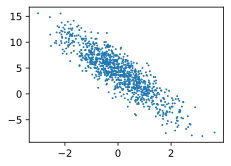

In [4]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(features[:,1]), d2l.numpy(labels), 1)

### Reading the dataset

function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size. Each minibatch consists of a tuple of features and labels.

In [5]:
# a lazily called generator which generates features of batch_size 
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # step of batch_size
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j) #slices the params in the shape of params with the help of indices

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 1.4677842   2.230289  ]
 [-0.02807121 -0.08568624]
 [-0.2614903  -2.1048968 ]
 [ 0.9471016  -1.3504237 ]
 [-1.0884799   1.0711713 ]
 [ 1.4406611   0.35556063]
 [ 0.00447914  0.4232006 ]
 [-0.2931363   0.43966138]
 [-0.34856713  0.9974643 ]
 [ 0.06823988  0.7889925 ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[-0.44406575]
 [ 4.4306593 ]
 [10.845762  ]
 [10.687309  ]
 [-1.6213398 ]
 [ 5.8764215 ]
 [ 2.7676806 ]
 [ 2.124135  ]
 [ 0.09854677]
 [ 1.6636971 ]], shape=(10, 1), dtype=float32)


### Initializing Model parameters

trainable variables used for gradient computation

In [7]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean = 0, stddev = 0.01), trainable = True) 
b = tf.Variable(tf.zeros(1), trainable = True)

### Defining the model

In [8]:
def linreg(X, w, b):
    return tf.matmul(X, w) + b

### Defining the loss function

In [9]:
def squared_loss(y_hat, y):
    """squared loss"""
    return (y_hat-tf.reshape(y, y_hat.shape))** 2/2

### Defining the optimization algorithm

The size of the update step is determined by the learning rate lr. Because our loss is calculated as a 
sum over the minibatch of examples, we normalize our step size by the batch size (batch_size), so 
that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

we divide the total minibatch gradient with the size of the minibatch (which is m, so D=minibatch_grad/m) 
and then multiply by the learning rate, thus the greater effect on our step size towards the minimum is
heavily depend on lr rather than m.

In [10]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient"""
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad/batch_size) 
        

### Training

In each iteration, we will grab a minibatch of training examples, and pass
them through our model to obtain a set of predictions. After calculating the loss,we initiate the backwards 
pass through the network, storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm sgd to update the model parameters.

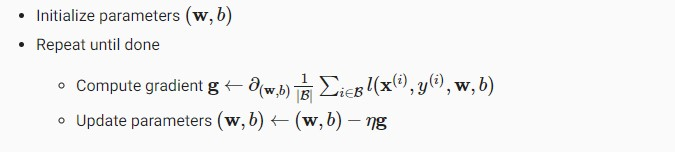

tf.GradientTape() says that Operations are recorded if they are executed within this context manager 
and at least one of their inputs is being "watched".

In [11]:
lr = 0.03
num_epochs = 3 
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y) # mini batch loss in 'X' and 'y'
        # compute gradient on l with respect to [w , b]
        dw, db = g.gradient(l, [w, b])
        # update the parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f"epoc {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}")

epoc 1, loss 0.029925
epoc 2, loss 0.000103
epoc 3, loss 0.000047


In [12]:
print(f"error in estimating w : {true_w -tf.reshape(w, true_w.shape)}")
print(f"error in estimating b : {true_b -b }")

error in estimating w : [-0.00024986  0.00026917]
error in estimating b : [-0.00010109]
